In [3]:
import os

# app preferences and configs
INTERACTIVE_READER = True
TOTAL_IMAGE_SNAPSHOTS = 10

# (w, h) used while training the data
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150

#directories
MODELS_DIRECTORY = os.path.join("public/models")
DATA_DIRECTORY = os.path.join("data")

# models
DNN_MODEL_PATH = os.path.join(MODELS_DIRECTORY, "opencv_face_detector_uint8.pb")
DNN_MODEL_CONFIG_PATH = os.path.join(MODELS_DIRECTORY, "opencv_face_detector.pbtxt")

In [4]:
import sys
import cv2
from urllib import request

# utility function to show progress size
def reporthook(count, block_size, total_size):
    percent = min((count * block_size * 100 / total_size), 100)
    sys.stdout.write("\r%.2f%%" % percent)
    sys.stdout.flush()

# utility function to download from url
def download_file(url, path):
  print(f"downloading from {url}...")
  request.urlretrieve(url,path,reporthook)
  print(f"\nfile saved to `{path}`.")

# get the face detector ( using opencv's dnn model)
def get_face_detector():
    # try to load models from directory
    # if doesn't exists, then create one
    if not os.path.isdir(MODELS_DIRECTORY):
        os.makedirs(MODELS_DIRECTORY)
    for file in [DNN_MODEL_PATH, DNN_MODEL_CONFIG_PATH]:
        if not os.path.isfile(file):
            url = f"https://raw.githubusercontent.com/sharmapukar217/realtime-face-recognization/main/{file}"
            download_file(url, file)

    # create dnn net from saved face detection model
    net = cv2.dnn.readNet(DNN_MODEL_PATH, DNN_MODEL_CONFIG_PATH)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    # get detetor from net
    detector = cv2.dnn_DetectionModel(net)
    detector.setInputParams(size=(200, 200), scale=1, mean=(104, 117, 123), swapRB=True)
    
    return detector

In [ ]:
import os
import sys
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile

FILE_NAME = "faces.rar"

if not os.path.isdir(DATA_DIRECTORY):
    os.mkdir(DATA_DIRECTORY)
    
if len(os.listdir(DATA_DIRECTORY)) == 0:
    if not os.path.isfile(FILE_NAME):
        download_file(f"https://raw.githubusercontent.com/sharmapukar217/realtime-face-recognization/main/{FILE_NAME}", FILE_NAME)
    detector = get_face_detector()
    with ZipFile(FILE_NAME, "r") as archive:
        namelist = list(filter(lambda x: (x.endswith(".png")), archive.namelist()))
        for file in tqdm(namelist):
            dirname = f"{DATA_DIRECTORY}/{file.split('/')[0]}"
            if not os.path.isdir(dirname): os.mkdir(dirname)
            
            image = archive.read(file)
            image = Image.open(BytesIO(image))
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            faces = detector.detect(image, 0.5)[2]
            if len(faces) != 0:
                x, y, w, h = faces[0]
                # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(f"{DATA_DIRECTORY}/{file}", cv2.resize(image[y:y+h, x:x+w], (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA))
        archive.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [02:42<00:00,  5.55it/s]


In [6]:
import tensorflow as tf

train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    seed=100,
    shuffle=True,
    subset="both",
    validation_split=0.20,
    # color_mode='grayscale',
    label_mode="categorical",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=None
)

AUTOTUNE = tf.data.AUTOTUNE
class_names = train_ds.class_names
print("splitting the validation set to test & validation.")

# 40% for testing model and 60% for validation while training model
test_size = int(len(validation_ds)* 0.4)
test_set = validation_ds.take(test_size)
validation_ds = validation_ds.skip(test_size)

print(f"Using {len(test_set)} files for testing.")
print(f"Using {len(validation_ds)} for validation.")

# now batch the train and validation dataset
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)

2023-04-28 23:32:38.251435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 722 files belonging to 9 classes.
Using 578 files for training.
Using 144 files for validation.


2023-04-28 23:33:15.987015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 23:33:16.139810: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


splitting the validation set to test & validation.
Using 57 files for testing.
Using 87 for validation.


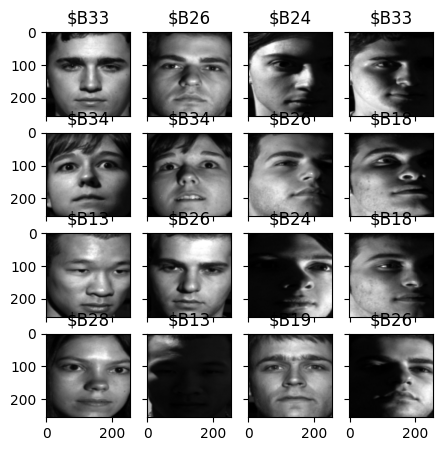

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,4, sharex=True, sharey=True, figsize=(5,5))

for images, labels in train_ds.take(1):
    for i in range(4):
        for j in range(4):
            ax[i][j].imshow(images[i*4+j].numpy().astype("uint8"), cmap="gray")
            label = class_names[np.argmax(labels[i*4+j])]
            ax[i][j].set_title(label)
plt.show()

In [11]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.Rescaling(1/127.0, offset=-1)
])

model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

NameError: name 'input_shape' is not defined